# Proyecto procesamiento de imagenes

In [2]:
import cv2
from pyzbar.pyzbar import decode
import matplotlib.pyplot as plt
import numpy as np
# Get file names in /png
import os
from IPython.display import clear_output

In [3]:
# Decode QR codes
def decode_qr(qr_image):
  decoded_objects = decode(qr_image)
  if not decoded_objects:
      return False, ""
  return True, decoded_objects[0].data.decode("utf-8")


def get_txt_content(file_name):
  with open(file_name, 'r') as file:
    content = file.read()
  return content

def checkQr(image, txt_file_path):
  content = get_txt_content(txt_file_path)

  ok, decoded = decode_qr(image)
  if ok:
    return decoded == content
  return False

In [4]:
class Pipeline:
    def __init__(self, steps):
        self.steps = steps

    def run(self, data, txt_path=None):
        for step in self.steps:
            data = step(data, txt_path)
        return data


In [5]:
# Different processing steps

def grayscale(image, txt_path):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def threshold(threshold_value=128):
    def inner(image, txt_path, threshold_value=threshold_value):
        _, thresholded_image = cv2.threshold(image, threshold_value, 255, cv2.THRESH_BINARY)
        return thresholded_image
    return inner

def multiple_thresholds(thresholds):
    def inner(image, txt_path, thresholds=thresholds):
        # Apply multiple thresholds and choose the best one
        if txt_path is None:
            print("Warning: No txt_path provided, can't perform multiple thresholds.")
            return image
        
        for threshold_value in thresholds:
            _, thresholded_image = cv2.threshold(image, threshold_value, 255, cv2.THRESH_BINARY)
            if checkQr(thresholded_image, txt_path):
                return thresholded_image
        return image  # Return original image if no threshold matches

    return inner


def otsu_threshold(image, txt_path):
    _, thresholded_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return thresholded_image

def histogram_based_threshold(image, txt_path):
    # Calculate histogram
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])

    # Calculate derivative of histogram
    derivative = np.gradient(hist.flatten())

    ## Plot derivative for debugging
    plt.plot(derivative)
    plt.title('Histogram Derivative')
    plt.xlabel('Pixel Value')
    plt.ylabel('Derivative')
    plt.show()

    # Find zero crossings in the derivative
    zero_crossings = cv2.findNonZero((derivative > 0).astype('uint8'))

    if zero_crossings is None or len(zero_crossings) == 0:
        return image
    
    # Find the index of the first zero crossing
    threshold_index = zero_crossings[0][0][0]
    threshold_value = threshold_index
    
    print(f"Calculated threshold value: {threshold_value}")

    
    # Apply threshold
    _, thresholded_image = cv2.threshold(image, threshold_value, 255, cv2.THRESH_BINARY)
    

    return thresholded_image

# Blurs
def gaussian_blur(kernel_size=5):
    def inner(image, txt_path, kernel_size=kernel_size):
        return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
    return inner

def median_blur(kernel_size=5):
    def inner(image, txt_path, kernel_size=kernel_size):
        return cv2.medianBlur(image, kernel_size)
    return inner

# Morphological operations
def opening(kernel):
    def inner(image, txt_path, kernel=kernel):
        return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
    return inner

def squared_opening(kernel_size=5):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
    return opening(kernel)

def closing(kernel):
    def inner(image, txt_path, kernel=kernel):
        return cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    return inner

def clahe_enhancement(clip_limit=2.0, tile_grid_size=(8, 8)):
    def inner(image, txt_path, clip_limit=clip_limit, tile_grid_size=tile_grid_size):
        clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
        return clahe.apply(image)
    return inner

In [6]:
def show_image(label, image):
  ## Create a plot
  plt.imshow(image, cmap='gray')
  plt.title(label)
  plt.axis('off')
  plt.show()

def plot_histogram(image):
  plt.hist(image.ravel(), bins=256, range=[0, 256])
  plt.title('Histogram')
  plt.xlabel('Pixel value')
  plt.ylabel('Frequency')
  plt.show()
    

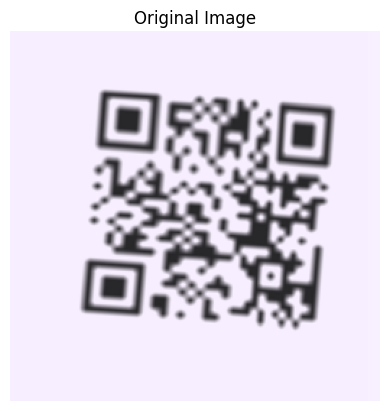

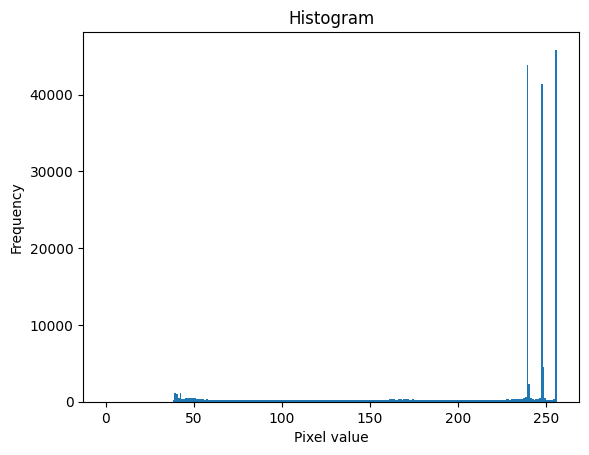

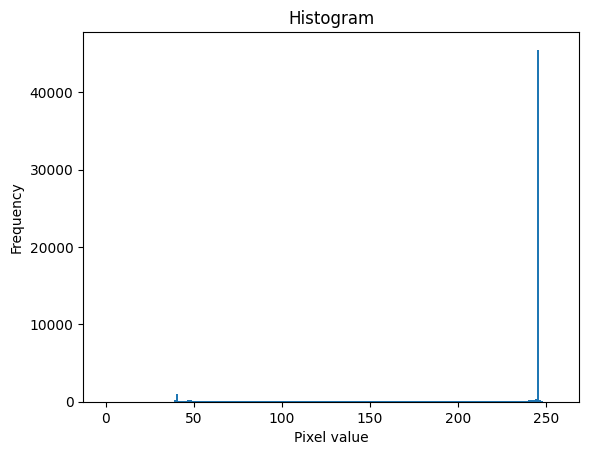

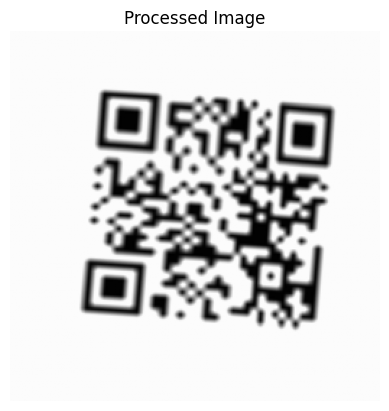

Original QR code validity: False
Processed QR code validity: False


In [ ]:
''' 
This script test the transformation pipeline for a single image.
'''
image_name = "000204"

image = cv2.imread(f"png/{image_name}.png")
if image is None:
    raise FileNotFoundError("Image not found. Please check the file path.")

## Show original image
show_image("Original Image", image)
plot_histogram(image)

## Create a pipeline with the steps
pipeline = Pipeline([
    grayscale,
    # median_blur(kernel_size=5),
    # histogram_based_threshold,
    # threshold(threshold_value=230),
    # multiple_thresholds(thresholds=[150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250]),
    # squared_opening(kernel_size=3),
    # clahe_enhancement(clip_limit=2.0, tile_grid_size=(15,15)),
    # bluring(kernel_size=3),
    # otsu_threshold,
])

# Run the pipeline
processed_image = pipeline.run(image)

# Show histogram of processed image
plot_histogram(processed_image)

# Show processed image
show_image("Processed Image", processed_image)

## Check if the QR code is valid
txt_file_path = f"txt/{image_name}.txt"
original_validity = checkQr(image, txt_file_path)
processed_validity = checkQr(processed_image, txt_file_path)

print(f"Original QR code validity: {original_validity}")
print(f"Processed QR code validity: {processed_validity}")


In [9]:
'''
This script processes images in a directory, aplying a series of transformations defined in a pipeline.
'''



def checAll():
  files = os.listdir("png")
  files = [file.split(".")[0] for file in files]

  # Set pipeline
  pipeline = Pipeline([
      # threshold(128),
      # grayscale
  ])

  # Initialize counters to compare original vs transformed 
  enhanced_count = 0
  worsened_count = 0
  same_ok_count = 0
  same_false_count = 0


  for file in files:
    # Read image
    img = cv2.imread("png/" + file + ".png")
    if img is None:
      print(f"Image {file}.png not found.")
      continue

    # Read text file
    file_name = "txt/" + file + ".txt"

    # Apply pipeline
    img_transformed = pipeline.run(img)

    # Show result of pipeline 
    ok = checkQr(img, file_name)
    transformed_ok  = checkQr(img_transformed, file_name)

    if ok:
      if transformed_ok: same_ok_count += 1
      else: worsened_count += 1
    else:
      if transformed_ok: enhanced_count += 1
      else: same_false_count += 1
  

  # Print summary
  print(f"Total images: {len(files)}")
  print(f"enhanced_count: {enhanced_count}")
  print(f"worsened_count: {worsened_count}")
  print(f"same_ok_count: {same_ok_count}")
  print(f"same_false_count: {same_false_count}")


## Run the check for all images
# checAll()


In [18]:
# Divides images in 2 folders depending on if they are recognized by the scan or not.
def divide_imgs_by_scan(folder_path, pipeline=None, pipeline_name=""):
    recognized_count = 0
    not_recognized_count = 0
    # Here we scan the images to see how much are recognized and not
    for filename in os.listdir(folder_path):
        if filename.endswith(".png"):
            img_path = os.path.join(folder_path, filename)
            og_img = cv2.imread(img_path)
            if og_img is None:
                print(f"Image {filename} not found.")
                continue

            txt_file_path = f"txt/{filename.split('.')[0]}.txt"

            # Apply pipeline if provided
            if pipeline:
                img = pipeline.run(og_img, txt_file_path)
            else:
                # This is to make sure the original image is used if no pipeline is provided
                img = og_img
            
            # Check QR code validity
            ok = checkQr(img, txt_file_path)

            if ok:
                recognized_count += 1
                print(f"Image {filename} recognized.")
            else:
                not_recognized_count += 1
                print(f"Image {filename} not recognized.")
    
    print(f"Total images scanned: {recognized_count + not_recognized_count}")
    print(f"Recognized images with pipeline {pipeline_name}: {recognized_count}")
    print(f"Not recognized images with pipeline {pipeline_name}: {not_recognized_count}")
    choice = input("Do you want to move the images to separate folders? (y/n)")
    if choice.lower() != 'y':
        print("Exiting without moving images.")
        return

    # Before the for loop in divide_imgs_by_scan
    #os.makedirs(os.path.join(folder_path,pipeline_name+"_recognized"), exist_ok=True)
    #os.makedirs(os.path.join(folder_path,pipeline_name+"_not_recognized"), exist_ok=True)
    os.makedirs("processed_qrs", exist_ok=True)
    os.makedirs(os.path.join("processed_qrs", pipeline_name+"_recognized"), exist_ok=True)
    os.makedirs(os.path.join("processed_qrs", pipeline_name+"_not_recognized"), exist_ok=True)
    for filename in os.listdir(folder_path):
        if filename.endswith(".png"):
            img_path = os.path.join(folder_path, filename)
            og_img = cv2.imread(img_path)
            if og_img is None:
                print(f"Image {filename} not found.")
                continue
            
            txt_file_path = f"txt/{filename.split('.')[0]}.txt"
            
            # Apply pipeline if provided
            if pipeline:
                img = pipeline.run(og_img, txt_file_path)
            else:
                # This is to make sure the original image is used if no pipeline is provided
                img = og_img

            # Check QR code validity
            ok = checkQr(img, txt_file_path)

            # Move image to appropriate folder
            target_folder = os.path.join("processed_qrs", pipeline_name + ("_recognized" if ok else "_not_recognized"))
            target_path = os.path.join(target_folder, filename)
            #target_path = os.path.join(folder_path, target_path)
            cv2.imwrite(target_path, og_img)
            print(f"Moved {filename} to {target_folder}")

def show_random_images(folder_path, n=5):
    print(f"Showing {n} random images from {folder_path}")
    images = [f for f in os.listdir(folder_path) if f.endswith('.png')]
    selected_images = np.random.choice(images, n, replace=False)
    
    plt.figure(figsize=(15, 10))
    for i, img_name in enumerate(selected_images):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            plt.subplot(1, n, i + 1)
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.title(img_name)
            plt.axis('off')
    plt.show()

In [17]:
divide_imgs_by_scan("png")

Image 000000.png recognized.
Image 000001.png not recognized.
Image 000002.png recognized.
Image 000003.png recognized.
Image 000004.png recognized.
Image 000005.png not recognized.
Image 000006.png recognized.
Image 000007.png not recognized.
Image 000008.png recognized.
Image 000009.png recognized.
Image 000010.png recognized.
Image 000011.png recognized.
Image 000012.png not recognized.
Image 000013.png recognized.
Image 000014.png not recognized.
Image 000015.png not recognized.
Image 000016.png recognized.
Image 000017.png not recognized.
Image 000018.png not recognized.
Image 000019.png not recognized.
Image 000020.png recognized.
Image 000021.png recognized.
Image 000022.png not recognized.
Image 000023.png not recognized.
Image 000024.png not recognized.
Image 000025.png not recognized.
Image 000026.png not recognized.
Image 000027.png recognized.
Image 000028.png not recognized.
Image 000029.png not recognized.
Image 000030.png not recognized.
Image 000031.png not recognized.


Showing 10 random images from processed_qrs/_recognized


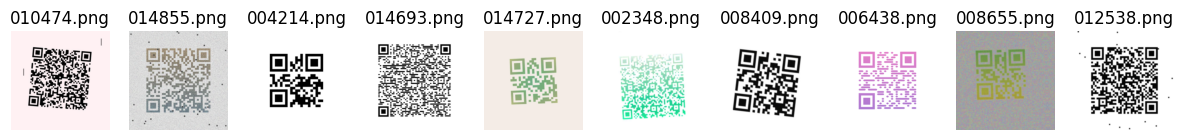

Showing 10 random images from processed_qrs/_not_recognized


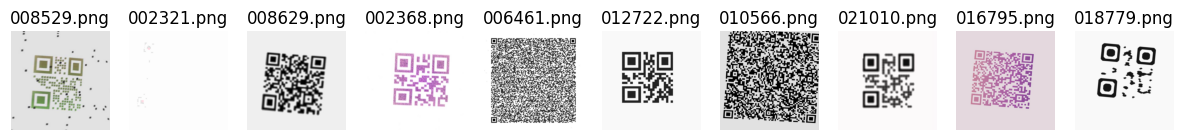

In [11]:
show_random_images("processed_qrs/_recognized", n=10)
show_random_images("processed_qrs/_not_recognized", n=10)

In [12]:
pipeline = Pipeline([
    grayscale
])
divide_imgs_by_scan("processed_qrs/_not_recognized", pipeline=pipeline, pipeline_name="grayscale")

Image 000001.png not recognized.
Image 000005.png not recognized.
Image 000007.png not recognized.
Image 000012.png not recognized.
Image 000014.png not recognized.
Image 000015.png not recognized.
Image 000017.png not recognized.
Image 000018.png not recognized.
Image 000019.png not recognized.
Image 000022.png recognized.
Image 000023.png recognized.
Image 000024.png not recognized.
Image 000025.png not recognized.
Image 000026.png not recognized.
Image 000028.png not recognized.
Image 000029.png not recognized.
Image 000030.png not recognized.
Image 000031.png not recognized.
Image 000033.png not recognized.
Image 000034.png not recognized.
Image 000035.png not recognized.
Image 000036.png not recognized.
Image 000038.png not recognized.
Image 000045.png not recognized.
Image 000046.png not recognized.
Image 000050.png recognized.
Image 000055.png not recognized.
Image 000056.png not recognized.
Image 000059.png not recognized.
Image 000066.png not recognized.
Image 000070.png not r

Showing 10 random images from processed_qrs/grayscale_not_recognized


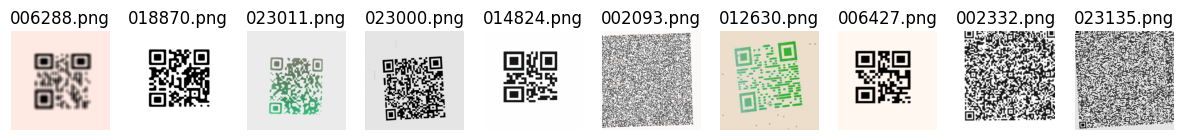

Showing 10 random images from processed_qrs/grayscale_recognized


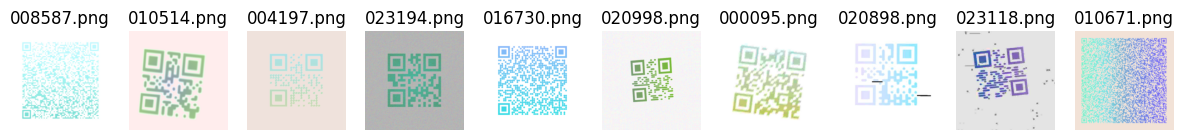

In [13]:
show_random_images("processed_qrs/grayscale_not_recognized", n=10)
show_random_images("processed_qrs/grayscale_recognized", n=10)

Vemos que las imagenes reconocidas aplicando grayscale son imagenes a colores, que es lo esperado

In [19]:
pipeline = Pipeline([
    grayscale,
    multiple_thresholds(thresholds=[90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250]),
])
divide_imgs_by_scan("processed_qrs/grayscale_not_recognized", pipeline=pipeline, pipeline_name="grayscale_multiple_thresholds")

Image 000001.png not recognized.
Image 000005.png not recognized.
Image 000007.png not recognized.
Image 000012.png not recognized.
Image 000014.png not recognized.
Image 000015.png not recognized.
Image 000017.png not recognized.
Image 000018.png not recognized.
Image 000019.png not recognized.
Image 000024.png not recognized.
Image 000025.png not recognized.
Image 000026.png recognized.
Image 000028.png not recognized.
Image 000029.png not recognized.
Image 000030.png not recognized.
Image 000031.png not recognized.
Image 000033.png recognized.
Image 000034.png not recognized.
Image 000035.png not recognized.
Image 000036.png not recognized.
Image 000038.png not recognized.
Image 000045.png not recognized.
Image 000046.png not recognized.
Image 000055.png recognized.
Image 000056.png not recognized.
Image 000059.png not recognized.
Image 000066.png not recognized.
Image 000070.png recognized.
Image 000071.png not recognized.
Image 000076.png not recognized.
Image 000077.png recognize

In [ ]:
# counts how many are in a folder
def count_images_in_folder(folder_path):
    count = 0
    for filename in os.listdir(folder_path):
        if filename.endswith(".png"):
            count += 1
    return count


Number of images in thresholded100_recognized: 19
Number of images in thresholded110_recognized: 9
Number of images in thresholded120_recognized: 8
Number of images in thresholded130_recognized: 7
Number of images in thresholded140_recognized: 2
Number of images in thresholded150_recognized: 5
Number of images in thresholded160_recognized: 7
Number of images in thresholded170_recognized: 5
Number of images in thresholded180_recognized: 12
Number of images in thresholded190_recognized: 6
Number of images in thresholded200_recognized: 2
Number of images in thresholded210_recognized: 2
Number of images in thresholded220_recognized: 4
Number of images in thresholded230_recognized: 3
Number of images in thresholded240_recognized: 7
Number of images in thresholded250_recognized: 3
Total number of images in all thresholded folders: 101
